# NRCS SIMWE Workshop

In [4]:
import os
import subprocess
import sys
# import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from PIL import Image 
import pandas as pd
import sqlite3
from IPython.display import IFrame


# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ["GISBASE"] = gisbase
print(gisbase)

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs

# Import GRASS Jupyter
import grass.jupyter as gj

/usr/local/grass83


## Initialize GRASS Jupyter

In [331]:
gisdb = os.path.join(os.getenv('HOME'), 'grassdata')
site = 'tx069-playas'
gj.init(gisdb, site, 'basic') # 10 m
# gj.init(gisdb, 'coweeta', 'basic') # 10 m
# gj.init(gisdb, 'SFREC', 'basic') # 1 m
# gj.init(gisdb, 'SJER', 'basic') # 1 m
# gj.init(gisdb, 'tx069-playas', 'basic') # 8 m
# gj.init(gisdb, 'clay-center', 'basic') # 3 m



In [332]:
gs.run_command('g.region', raster='elevation', flags='pa')

projection: 1 (UTM)
zone:       13
datum:      wgs84
ellipsoid:  wgs84
north:      3828447.35560415
south:      3811791.35560415
west:       755357.33549331
east:       776005.33549331
nsres:      8
ewres:      8
rows:       2082
cols:       2581
cells:      5373642


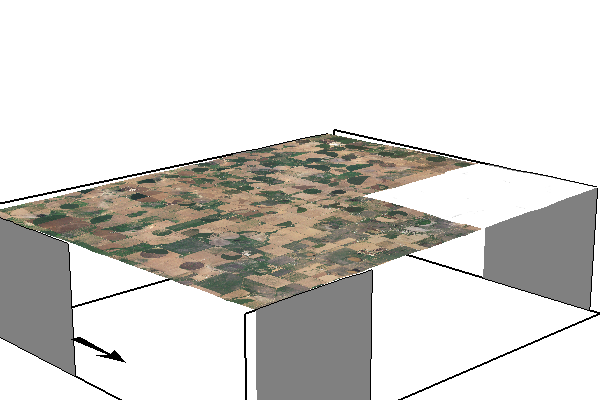

In [336]:
elevation_3dmap = gj.Map3D(filename=f"../output/{site}/elevation_3dmap.png")
# Full list of options m.nviz.image
# https://grass.osgeo.org/grass83/manuals/m.nviz.image.html
elevation_3dmap.render(
    elevation_map="elevation",
    color_map="naip_2022_rgb@naip", # coweeta, SFREC
    # color_map="naip_2021_rgb@naip", # clay-center
    # perspective=20, # coweeta
    # height=6000, # coweeta
    # perspective=20, # SJER
    # height=1000, # SJER
    # perspective=15, # SJER
    # height=5000, # SJER20
    zexag=5, # tx069-playas
    perspective=18, # SFREC
    height=4000, # SFREC
    resolution_fine=1,
    # perspective=15, # clay center
    # height=750, # clay center
    fringe=['ne','nw','sw','se'],
    fringe_elevation=55,
    arrow_position=[100,50],
)
# elevation_3dmap.overlay.d_legend(raster="elevation", at=(60, 97, 87, 92))
elevation_3dmap.show()

In [219]:
gs.run_command('r.info', map='aspect')  

 +----------------------------------------------------------------------------+
 | Map:      aspect                         Date: Thu Jun  6 13:53:35 2024    |
 | Mapset:   basic                          Login of Creator: coreywhite      |
 | Project:  clay-center                                                      |
 | DataBase: /home/coreywhite/grassdata                                       |
 | Title:    Aspect counterclockwise in degrees from east                     |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 360             |
 |   Data Type:    FCELL                Semantic label: (none)                |
 |   Rows:         387                                                        |
 |   Columns:      459                  

In [220]:
gs.run_command('r.colors', map='elevation', color='elevation')

## Elevation data

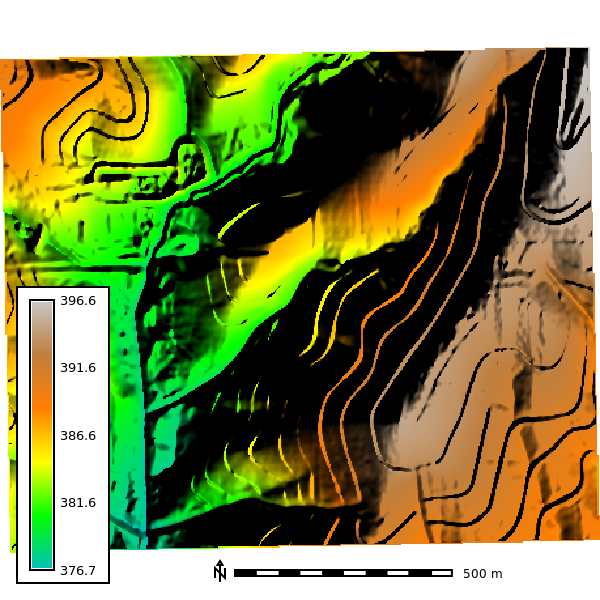

In [221]:
dem_map = gj.Map(use_region=True, height=600, width=600, filename=f"output/{site}_elev.png")
dem_map.d_shade(color="elevation", shade="aspect")
dem_map.d_legend(raster="elevation", at=(5,50,5,9), flags="b")
dem_map.d_barscale(at=(35,7), flags="n")
dem_map.show()

### Elevation Histogram

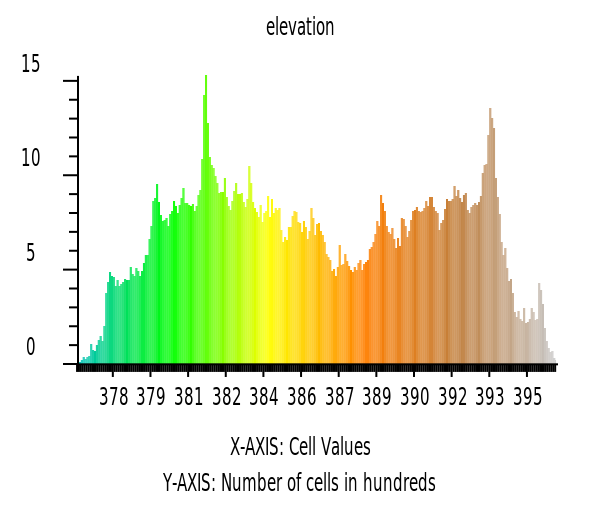

In [222]:
dem_hist = gj.Map(filename=f"output/{site}_hist.png", use_region=True)
dem_hist.d_histogram(map="elevation")
dem_hist.show()

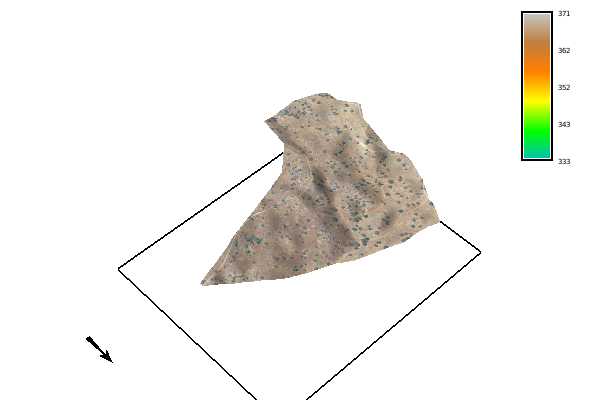

In [231]:
elevation_3dmap = gj.Map3D()
# Full list of options m.nviz.image
# https://grass.osgeo.org/grass83/manuals/m.nviz.image.html
elevation_3dmap.render(
    elevation_map="elevation",
    color_map="naip_2022_rgb@naip",
    perspective=20,
    height=3000,
    # vline="roadsmajor",
    # vline_color="blue",
    # vpoint="hospitals",
    # vpoint_color="red",
    # vpoint_marker="basic/circle",
    # vpoint_size=200,
    fringe=['ne','nw','sw','se'],
    arrow_position=[100,50],
)
elevation_3dmap.overlay.d_legend(raster="elevation", at=(60, 97, 87, 92))
elevation_3dmap.show()

## ssurgo mukey

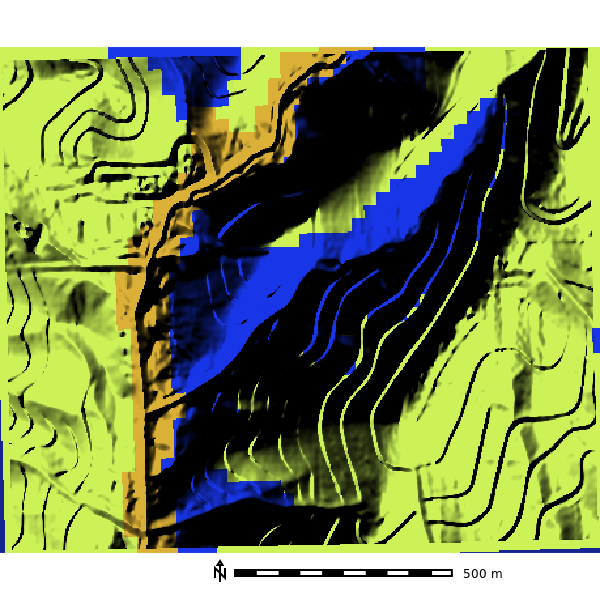

In [226]:

dem_map = gj.Map(use_region=True, height=600, width=600, filename=f"output/{site}_ssurgo_mukey.png")
dem_map.d_shade(color="ssurgo_mukey", shade="aspect")
dem_map.d_barscale(at=(35,7), flags="n")
dem_map.show()

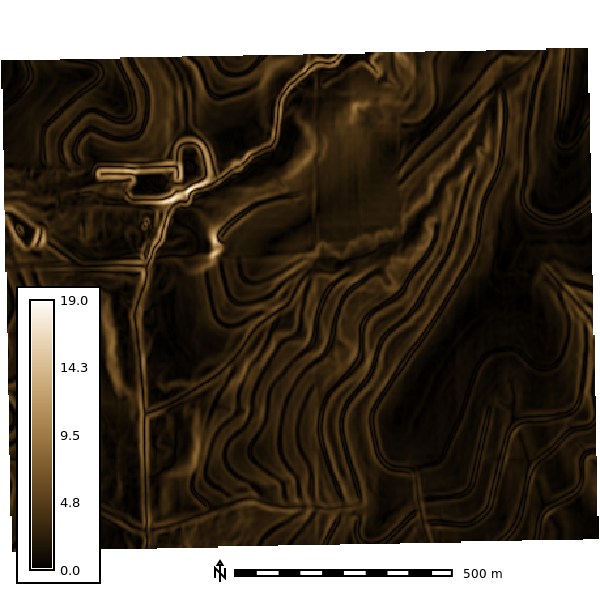

In [224]:
dem_map = gj.Map(use_region=True, height=600, width=600, filename=f"output/{site}_slope.png")
dem_map.d_rast(map="slope")
dem_map.d_legend(raster="slope", at=(5,50,5,9), flags="b")
dem_map.d_barscale(at=(35,7), flags="n")
dem_map.show()

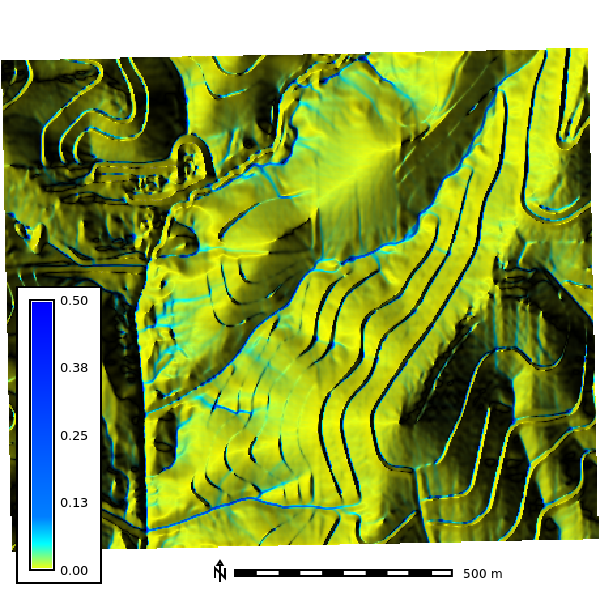

In [198]:
dem_map = gj.Map(use_region=True, height=600, width=600, filename=f"output/{site}_depth10.png")
dem_map.d_shade(color="depth.10", shade="aspect")
dem_map.d_legend(raster="depth.10", at=(5,50,5,9), flags="b")
dem_map.d_barscale(at=(35,7), flags="n")
dem_map.show()

In [199]:
gs.run_command(
    "t.create",
    output="depth_sum",
    type="strds",
    temporaltype="absolute",
    title="Runoff Depth",
    description="Runoff Depth in [m]",
)

depth_list = gs.read_command(
    "g.list", type="raster", pattern="depth.*", separator="comma"
).strip()


gs.run_command(
    "t.register",
    input="depth_sum",
    type="raster",
    start="2023-01-01",
    increment="2 minutes",
    maps=depth_list,
    flags="i",
)

In [200]:
depth_sum_ts_map = gj.TimeSeriesMap(height=600, width=600, use_region=True)
depth_sum_ts_map.add_raster_series("depth_sum")
depth_sum_ts_map.d_legend()
depth_sum_ts_map.render()
depth_sum_ts_map.save(f"./output/{site}.gif")
depth_sum_ts_map.show()

In [211]:
import matplotlib.pyplot as plt
from PIL import Image
import grass.jupyter as gj

def generate_plots(n_rows, n_cols, plot_params, figure_name):
    fig = plt.figure(figsize=(25, 30))
    fig.subplots_adjust(hspace=0, wspace=0.1)

    for i, params in enumerate(plot_params):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        ax.set_axis_off()
        # map_obj = gj.Map(filename=params['filename'], use_region=True)
        # map_obj.d_rast(map=params['rast_map'])
        # map_obj.d_vect(map="roadsmajor", color="black")
        # map_obj.d_region_grid(raster=params['rast_map'])
        img = Image.open(params['filename'])
        plt.imshow(img)
        ax.set_title(params['rast_map'], {"fontsize": 24, "fontweight": "bold"})
        
        # Add section title for each row
        if i % n_cols == 0:
            section_title = f"{params['title']}"
            ax.annotate(section_title, xy=(0, 0), xytext=(0, -50), textcoords="offset points",
                         ha='center', va='top', fontsize=24, fontweight='bold', rotation=90)

    plt.tight_layout()
    plt.savefig(figure_name, bbox_inches="tight", dpi=300)
    plt.show()

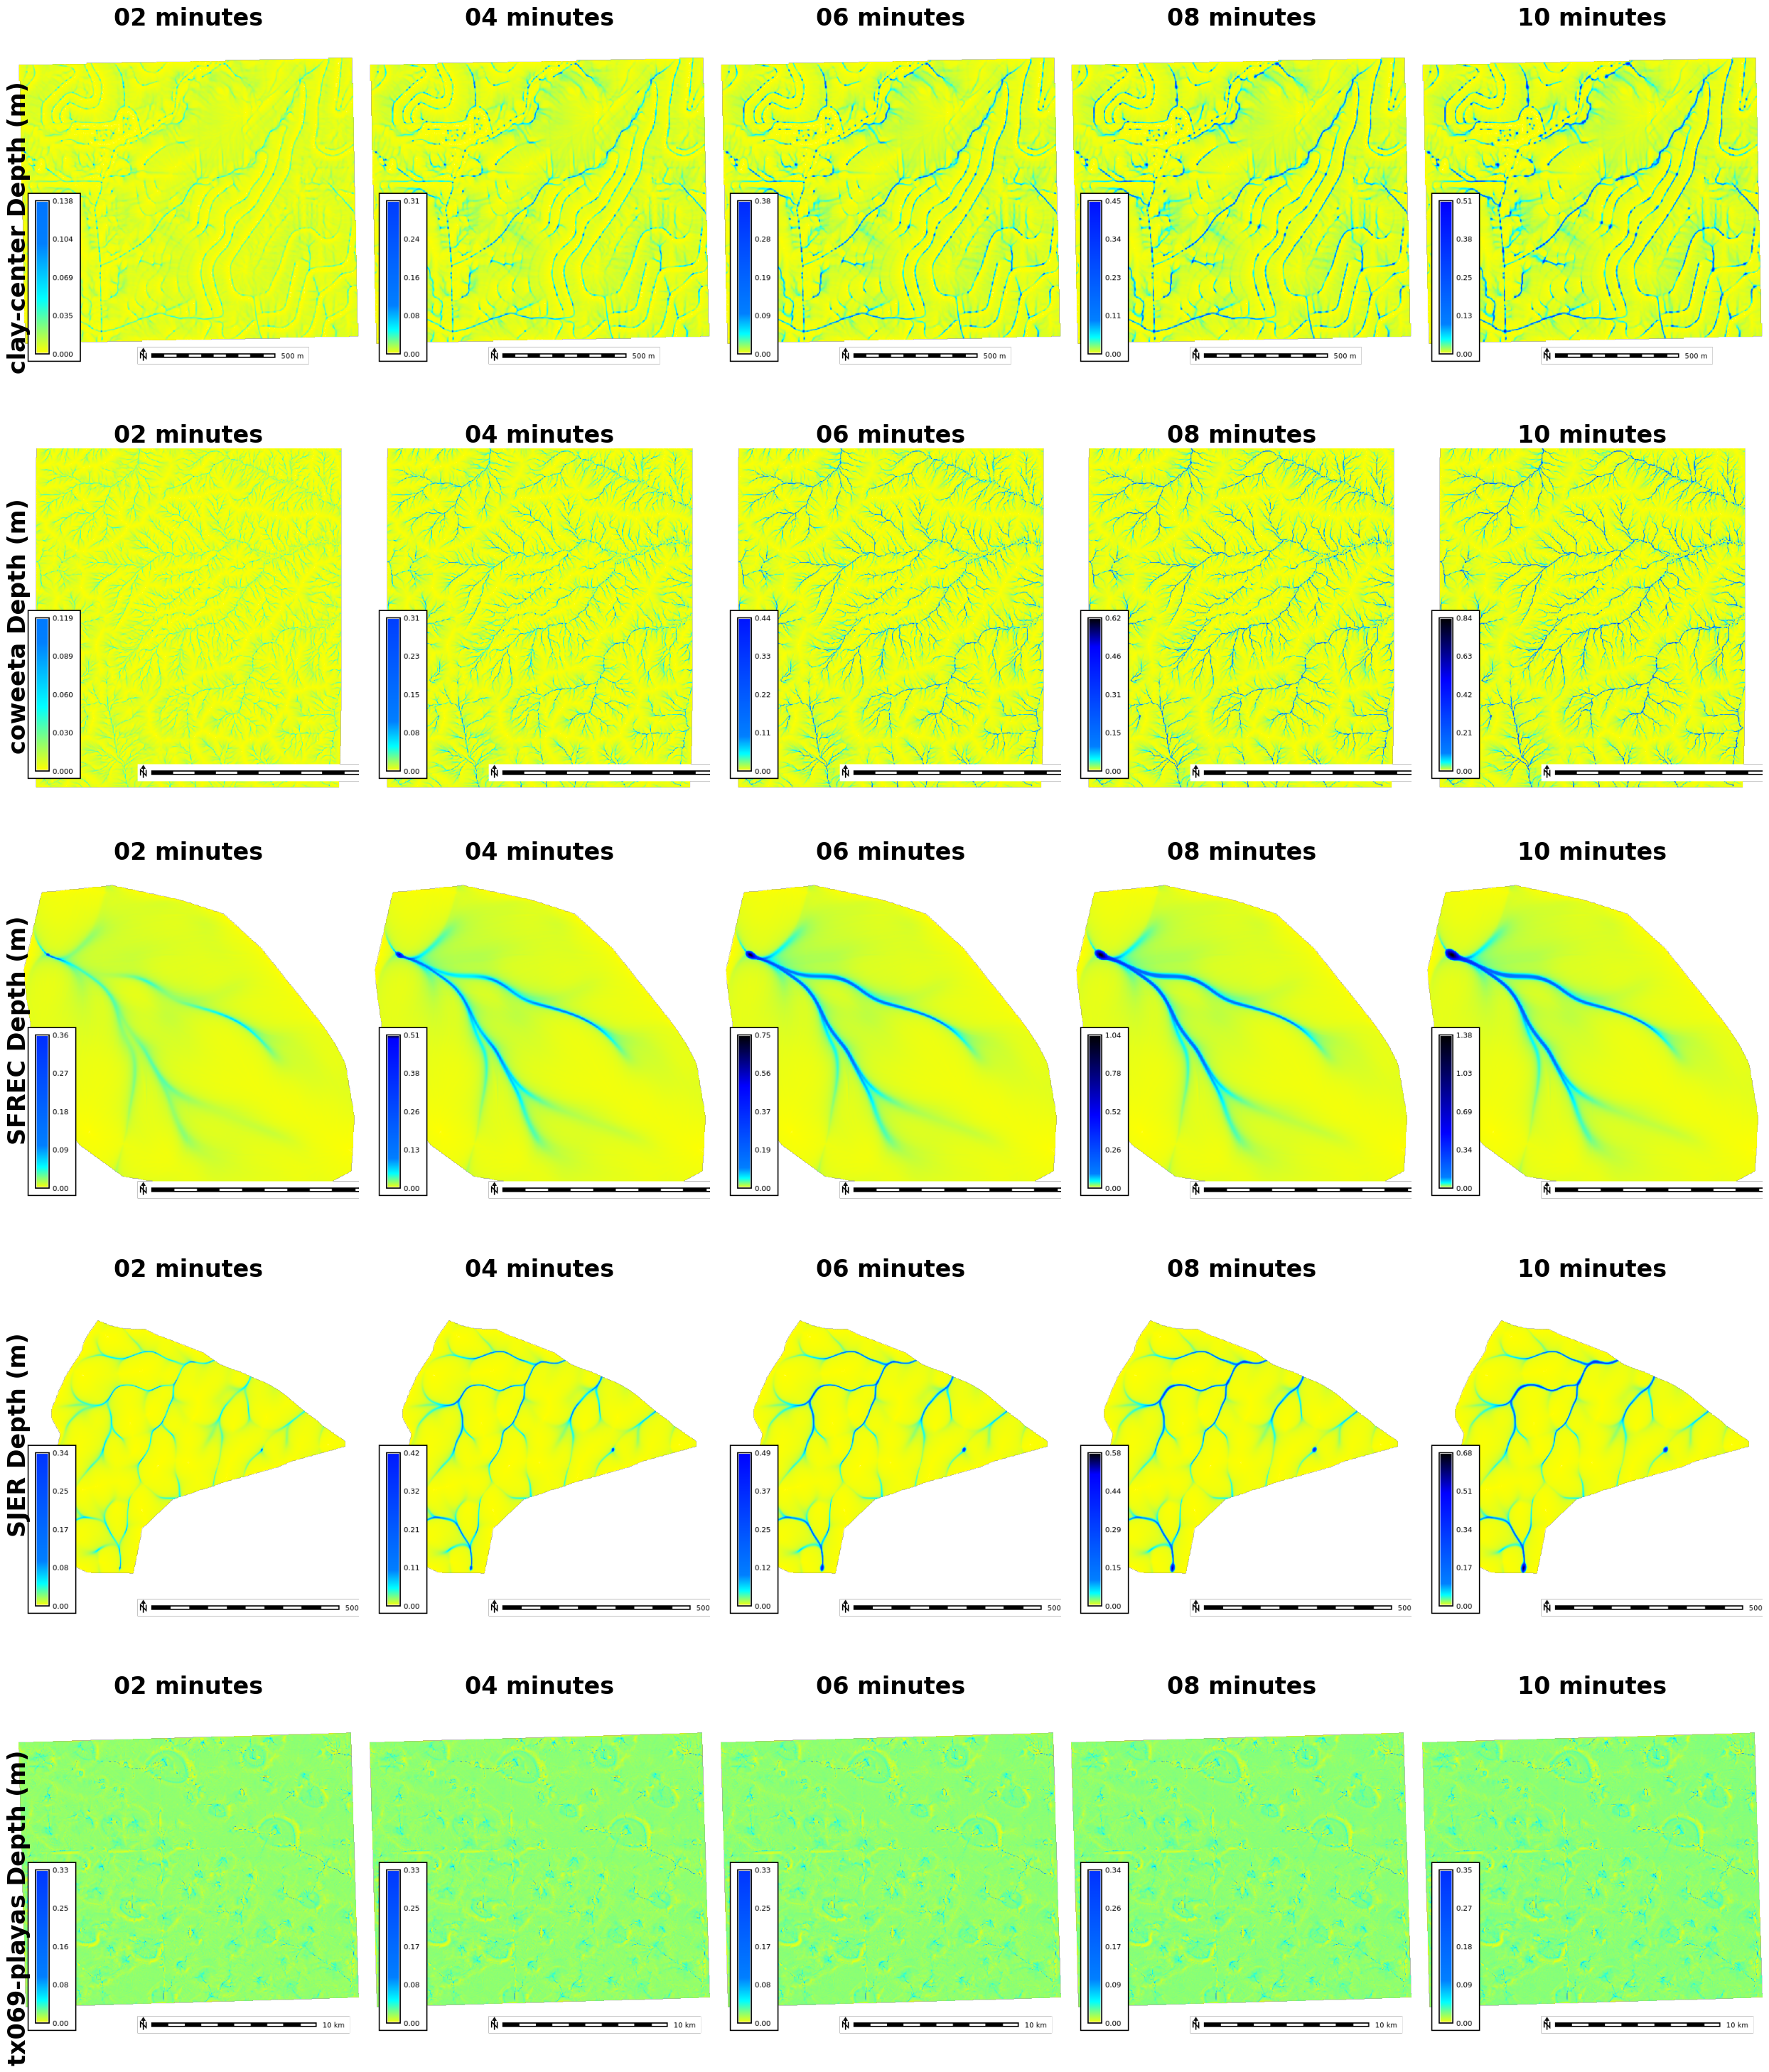

In [237]:
site_params = [
    {'site': 'clay-center', 'crs': '32614', 'res': '3'},
    {'site': 'coweeta', 'crs': '26917', 'res': '10'},
    {'site': 'SFREC', 'crs': '26910', 'res': '1'},
    {'site': 'SJER', 'crs': '26911', 'res': '1'},
    {'site': 'tx069-playas', 'crs': '32613', 'res': '8'}
]

depth_plot_params = []
depth_values = [str(i).zfill(2) for i in range(2, 11, 2)]
for site in site_params:
    for i in depth_values:
        map_name = f"depth.{i}"
        filename = f"output/{site['site']}_depth{i}.png"
        gj.init(gisdb, site['site'], 'basic')
        map_obj = gj.Map(filename=filename, use_region=True, height=600, width=600)
        map_obj.d_rast(map=map_name)
        # map_obj.d_shade(color=map_name, shade="aspect")
        map_obj.d_legend(raster=map_name, at=(5,50,5,9), flags="b")
        map_obj.d_barscale(at=(35,7), flags="n")
        map_obj.show()
        depth = {
            'filename': filename,
            'title': f"{site['site']} Depth (m)",
            'rast_map': f"{i} minutes"
        }
        depth_plot_params.append(depth)
    

generate_plots(5, 5, depth_plot_params, "./output/depth_fig.png")